<a href="https://colab.research.google.com/github/chengche6230/Deep-Learning-Course-Team-Project/blob/Comp1_Wen/reference_UCI_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !cd ./gdrive/MyDrive/NTHU/DL/Comp1/src/
os.chdir("/content/gdrive/MyDrive/NTHU/DL/Comp1/src") #更改路徑
os.getcwd() #查看當前路徑

'/content/gdrive/MyDrive/NTHU/DL/Comp1/src'

In [ ]:
!ls

test_top5_predict_with5channel.csv  top_5.ipynb  Untitled0.ipynb


In [ ]:
!pip install text2emotion

     |████████████████████████████████| 57 kB 3.1 MB/s 
     |████████████████████████████████| 170 kB 11.6 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=880c58da2e8cefbe8215e93e09d261fa18e86d677526148e88d118e23051a6ab
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import os, itertools, csv
import matplotlib.pyplot as plt
from tqdm import trange

# text related
import re
from bs4 import BeautifulSoup
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import text2emotion as te

# sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.impute import SimpleImputer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import nltk
from nltk import word_tokenize

def count_words(text):
    return len(text.split())

def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

def count_sentence(text):
    x = re.split(r'[.!?]+', text)
    return len(x) - 1

In [ ]:
def data_preprocess(text):
    bs = BeautifulSoup(text, 'html.parser')
    
    title = bs.find(class_="title").text
    content = bs.find(class_="article-content").text
    channel = bs.find("article")["data-channel"]
    
    
    # tag = bs.find(class_="article-topics").text
    # match = re.compile('Topics:')
    # tag = match.sub(r' ', tag)
    topic_tags = bs.find('footer', class_="article-topics").find_all('a')
    topics = [t.get_text() for t in topic_tags]
    tag = ' '.join(topics)
    fig_count = len(bs.find_all('img'))
    link_count = len(bs.find_all('a'))
    
    # Major channel: Lifestyle、Entertainment、Business、Social Media、Tech、World
    is_lifestyle = 1 if channel == 'lifestyle' else 0
    is_entertainment = 1 if channel == 'entertainment' else 0
    is_bus = 1 if channel == 'bus' else 0
    is_socmed = 1 if channel == 'socmed' else 0
    is_tech = 1 if channel == 'tech' else 0
    is_world = 1 if channel == 'world' else 0

    ### Modify area
    # word_count = len(text.split())
    # capital_word_count = sum(map(str.isupper,text.split()))
    sentence_count = count_sentence(text)
    # unique_word_count = len(set(text.split()))
    # htags_count = re.findall(r'(#w[A-Za-z0-9]*)', text)
    words_in_quotes_count = count_words_in_quotes(text)
    # stopwords_count = count_stopwords(text)
    
    time = bs.find('time')
    timestamp, weekday, month = np.NaN, np.NaN, np.NaN
    if time.has_attr('datetime'):
        time = datetime.strptime(time['datetime'], '%a, %d %b %Y %H:%M:%S %z')
        weekday = 0 if time.weekday() > 4 else 1
        month = 1 if time.month > 5 else 0
        timestamp = time.timestamp()

    # Emotion
    emo_val = 0
    for v in list(te.get_emotion(title).values()):
        if type(v)==int:
            break
        emo_val += v**2 if v!=0 else 0

    return {
            "title": title, 
            "content": content,
            "tag":  tag,
            "channel": channel, 
            "fig_count":  fig_count,
            "link_count":  link_count,
            "weekday":  weekday,
            "month": month,
            "timestamp":  timestamp,
            "word_count": words_in_quotes_count,
            "sentence_count": sentence_count,
            "emo_val": emo_val,
            "is_lifestyle": is_lifestyle,
            "is_entertainment": is_entertainment,
            "is_bus": is_bus,
            "is_socmed": is_socmed,
            "is_tech": is_tech,
            "is_world": is_world,
            }

# data_preprocess(df.loc[0,'Page content'])

In [ ]:
def preprocessor(text):
    """
    - remove HTML tags
    - remove punctuation
    - convert to lowercase
    """
    text = text#[0]
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    """
    - tokenization
    - word-stemming
    - remove stop-word
    """
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Custom transformer for sklearn pipeline
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols_from, cols_to):
        self.cols_from = cols_from
        self.cols_to = cols_to

    def transform(self, X):
        col_data = pd.DataFrame()
        col_data = X.iloc[:, self.cols_from:self.cols_to]
        return col_data.values

    def fit(self, X, y=None):
        return self

In [ ]:
attribute = ["title", "content", "tag",
            "channel", "fig_count", "link_count",
            "weekday", "month", "timestamp",
            "word_count", "sentence_count", "emo_val", 
            "is_lifestyle", "is_entertainment", "is_bus", "is_socmed", "is_tech", "is_world"]
df = pd.read_csv('../data/train.csv')
df.head()

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

train_data = pd.DataFrame(columns=attribute)
train_label = pd.DataFrame(columns=["Popularity"])
for i in trange(len(df)):
    train_data = train_data.append(data_preprocess(df.loc[i,'Page content']), ignore_index=True)
    train_label = train_label.append({"Popularity": df.loc[i, "Popularity"]}, ignore_index=True)
    
train_data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 27643/27643 [36:27<00:00, 12.64it/s]


,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val,is_lifestyle,is_entertainment,is_bus,is_socmed,is_tech,is_world
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,world,1,22,1,1,1.371654e+09,1,84,0.500,0,0,0,0,0,1
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,tech,2,18,1,0,1.364492e+09,1,54,0.625,0,0,0,0,1,0
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,entertainment,2,11,1,0,1.399490e+09,26,300,0.000,0,1,0,0,0,0
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,watercooler,1,13,1,1,1.381458e+09,21,214,0.000,0,0,0,0,0,0
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,entertainment,52,16,1,0,1.397706e+09,3,691,0.250,0,1,0,0,0,0


In [ ]:
label_le = LabelEncoder()
train_data["channel"] = label_le.fit_transform(train_data["channel"].values)

old_data = train_data
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['title','content', 'tag']), train_label['Popularity'].astype('int'),
                                                    test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(22114, 15) (22114,)
(5529, 15) (5529,)


,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val,is_lifestyle,is_entertainment,is_bus,is_socmed,is_tech,is_world
3492,3,2,15,1,1,1.383328e+09,2,40,0.5000,0,0,0,0,0,0
9375,3,2,8,1,1,1.409834e+09,2,45,0.0000,0,0,0,0,0,0
17129,20,1,14,1,1,1.387937e+09,1,58,0.5578,0,0,0,0,0,0
27200,31,1,15,1,1,1.413211e+09,1,33,0.0000,0,0,0,0,0,0
22507,28,21,39,0,0,1.358004e+09,1,352,1.0000,0,0,0,0,1,0


In [ ]:
# param
param_est = [50, 200, 500, 800]
param_depth = [2, 5, 10, 15]
param_grid = [{'clf__n_estimators': param_est, 
        'clf__max_depth': param_depth}]

pipe = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_jobs=-1, random_state=1))
                ])

gs = GridSearchCV(
    estimator = pipe, 
    param_grid = param_grid, 
    scoring = 'roc_auc',
    cv = 10
)

gs = gs.fit(X_train, y_train)
print('[SVC: grid search]')
print('Validation roc_auc score: %.3f' % gs.best_score_)
print(gs.best_params_)

best_clf = gs.best_estimator_

[SVC: grid search]
Validation roc_auc score: 0.589
{'clf__max_depth': 10, 'clf__n_estimators': 500}


In [ ]:
tmpx_train, tmpx_test, tmpy_train, tmpy_test = train_test_split(train_data.drop(columns=['content']), train_label['Popularity'].astype('int'),
                                                    test_size=0.2, random_state=0)
tmpx_train.head()

,title,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val,is_lifestyle,is_entertainment,is_bus,is_socmed,is_tech,is_world
3492,Analyst: iPad Air Sales May Top 3 Million This...,Apple Business Gadgets iPad iPad Air iPad Mini...,3,2,15,1,1,1.383328e+09,2,40,0.5000,0,0,0,0,0,0
9375,Vice Raises $500 Million in Its Quest for 'Tot...,Business Media VICE Media,3,2,8,1,1,1.409834e+09,2,45,0.0000,0,0,0,0,0,0
17129,Twitter Shares Soar to Record on Optimism for ...,Advertising Business Mobile Twitter,20,1,14,1,1,1.387937e+09,1,58,0.5578,0,0,0,0,0,0
27200,John Oliver Is Leading the War Against Pumpkin...,Coffee John Oliver Last Week Tonight With John...,31,1,15,1,1,1.413211e+09,1,33,0.0000,0,0,0,0,0,0
22507,10 Top News Stories This Week,CES Tech,28,21,39,0,0,1.358004e+09,1,352,1.0000,0,0,0,0,1,0


In [ ]:
param_est = [800, 1000, 1200]
param_depth = [5, 15, 20]
param_grid = [{'clf__n_estimators': param_est, 
               'clf__max_depth': param_depth}]
param_grid

[{'clf__max_depth': [5, 15, 20], 'clf__n_estimators': [800, 1000, 1200]}]

In [ ]:
type(tmpx_train)

pandas.core.frame.DataFrame

In [ ]:
from sklearn.compose import ColumnTransformer

numeric_features = ['channel', 'fig_count', 'link_count',
                    'weekday', 'month', 'timestamp', 
                    'word_count', 'sentence_count', 'emo_val', 
                    "is_lifestyle", "is_entertainment", "is_bus", "is_socmed", "is_tech", "is_world"]
numeric_transformer = Pipeline([ 
                                ('sc', StandardScaler()),
                                ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent'))
                            ])
########
# categorical_features = ['title']
# categorical_transformer = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)

# col_preprocessor = ColumnTransformer(transformers=[
#         ("num", numeric_transformer, numeric_features), 
#         ("cat", categorical_transformer, categorical_features)
# ])

# pipe_1 = Pipeline([("preprocessor", col_preprocessor),
#                 ('clf', RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=200, max_depth=10)) ])

# pipe_1.fit(tmpx_train, tmpy_train)
# print("model score: %.3f" % pipe_1.score(tmpx_test, tmpy_test))
########

# tf = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
tf = HashingVectorizer(n_features=2**4,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)
text_trans = tf.fit_transform(tmpx_train['tag']).toarray()
text_trans_2 = tf.fit_transform(tmpx_train['title']).toarray()

col_preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])
num_trans = col_preprocessor.fit_transform(tmpx_train)

tmpx_train = np.hstack((text_trans, text_trans_2, num_trans))
print("x_train shape:", tmpx_train.shape)

pipe = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, random_state=1))]) #, n_estimators=200, max_depth=10)

gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid, 
    scoring = 'roc_auc',
    cv = 10
)

gs = gs.fit(tmpx_train, tmpy_train)
print('[SVC: grid search]')
print('Validation roc_auc score: %.3f' % gs.best_score_)
print(gs.best_params_)

best_clf = gs.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


x_train shape: (22114, 47)
[SVC: grid search]
Validation roc_auc score: 0.590
{'clf__max_depth': 20, 'clf__n_estimators': 1000}


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Validation Accuracy: 0.5618
AUC: 0.5867


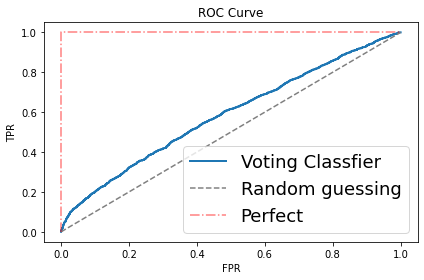

In [ ]:
# Best Model
text_trans = tf.fit_transform(tmpx_test['tag']).toarray()
text_trans_2 = tf.fit_transform(tmpx_test['title']).toarray()
num_trans = col_preprocessor.fit_transform(tmpx_test)

tmpx_test = np.hstack((text_trans, text_trans_2, num_trans))

X_test = tmpx_test
y_test = tmpy_test


proba = best_clf.predict_proba(X_test)
y_pred = best_clf.predict(X_test)
print('Validation Accuracy: %.4f' % accuracy_score(y_test, y_pred))
# Use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 proba[:, 1],
                                pos_label=1)
print('AUC: %.4f' % auc(fpr, tpr))


plt.plot(fpr, tpr, lw=2, label='Voting Classfier')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='-.', alpha=0.5, color='red', label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()

In [ ]:
df_real = pd.read_csv('../data/test.csv')

test_data = pd.DataFrame(columns=attribute)
for i in trange(len(df_real)):
    test_data = test_data.append(data_preprocess(df_real.loc[i,'Page content']), ignore_index=True)
    
label_le = LabelEncoder()
test_data["channel"] = label_le.fit_transform(test_data["channel"].values)
test_data.head()

100%|██████████| 11847/11847 [13:54<00:00, 14.20it/s]


,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count,sentence_count,emo_val,is_lifestyle,is_entertainment,is_bus,is_socmed,is_tech,is_world
0,Soccer Star Gets Twitter Death Threats After T...,Note to humanity: One Direction fandom ai...,Entertainment Music One Direction soccer Sports,5,1,30,1,1,1.378756e+09,8,128,0.5578,0,1,0,0,0,0
1,Google Glass Gets an Accessory Store,Shortly after announcing a hardware upgrade f...,Gadgets glass Google Google Glass Google Glass...,25,3,13,1,1,1.383212e+09,2,44,0.0000,0,0,0,0,1,0
2,OUYA Gaming Console Already Sold Out on Amazon,"Well, that was quick. Just hours after going ...",amazon amazon kindle Business Gaming,2,2,13,1,1,1.372165e+09,1,40,1.0000,0,0,0,0,0,0
3,'Between Two Ferns' Mocks Oscar Nominees,Between Two Ferns: Oscar Buzz Edition Part 1...,Between Two Ferns Movies The Oscars Oscars 201...,6,1,15,1,0,1.360726e+09,4,41,0.0000,0,0,0,0,0,0
4,'American Sniper' Trailer: Looks Like Eastwood...,Ever since The Hurt Locker it seems like ...,American Sniper Awards Bradley Cooper clint ea...,5,1,10,1,1,1.412300e+09,1,28,1.0000,0,1,0,0,0,0


In [ ]:
# Run first if choose the second model(text+num)

all_train = train_data.drop(columns=['content'])
text_trans = tf.fit_transform(all_train['tag']).toarray()
text_trans_2 = tf.fit_transform(all_train['title']).toarray()
num_trans = col_preprocessor.fit_transform(all_train)

all_train = np.hstack((text_trans, text_trans_2, num_trans))
print("Train shape:", all_train.shape)

all_test = test_data.drop(columns=['content'])
text_trans = tf.fit_transform(all_test['tag']).toarray()
text_trans_2 = tf.fit_transform(all_test['title']).toarray()
num_trans = col_preprocessor.fit_transform(all_test)

all_test = np.hstack((text_trans, text_trans_2, num_trans))
print("Test shape:", all_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train shape: (27643, 47)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Test shape: (11847, 47)


In [ ]:
'''
1st model: all_train/test -> train/test_data.drop(columns=[])
2nd model(text+num): run above block first
'''

best_clf.fit(all_train, train_label['Popularity'].astype('int'))
result = best_clf.predict_proba(all_test)
out = pd.DataFrame({'Id': df_real.Id, 'Popularity': result[:, 1]})
out.to_csv('referenceUCI_5_feature.csv', index=False)
print(out)

          Id  Popularity
0      27643    0.382833
1      27644    0.500234
2      27645    0.335652
3      27646    0.447288
4      27647    0.446180
...      ...         ...
11842  39485    0.697432
11843  39486    0.500116
11844  39487    0.566046
11845  39488    0.428853
11846  39489    0.457240

[11847 rows x 2 columns]


## Conclusion

從一開始只對 Page content 移除 HTML tag 、stop word 、和實作 hashingVectorizer 等 lecture 提過的方法，分數連 60 的 baseline 都到不了，後來決定加入一些時間資訊(weekday, month)，figure、link 數量此類的 scaler feature ，光是以上的scaler feature 其實就已經可以達到60 baseline了，為了再提升 performance，我們後來結合了文字與數字的feature，陸續加入channel的資訊、title emotion資訊等等，雖然知道不能過於在意 Public score 而一直去調整 feature 或者 tune 參數，不過比賽進行中難免